# Yelp Data Challenge - Topic Discovery Among Reviews
Restaurant owners would probably like to get a better understanding of diners, and data scientists can help by mining for recurring topics among reviews. 

Here we utilize latent semantic analysis (LSA, via SVD) and K-means clustering to achieve

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [4]:
df = pd.read_csv('data/last_2_years_restaurant_reviews.csv')
df.head(3)

,business_id,name,categories,avg_stars,attributes,cool,date,funny,review_id,stars,text,useful,user_id
0,2kWrSFkIes_d2BMg4YrRtA,Pizza Hut,"Restaurants, Pizza",2.5,"{'Alcohol': 'none', 'Ambience': ""{'romantic': ...",0,2017-04-01,0,Spl0fx_X6bjPASU-zUJQUA,1,"Ordered a pizza, the location is literally in ...",1,vZ-eQzpCOrSWfBfU5KUvIA
1,2kWrSFkIes_d2BMg4YrRtA,Pizza Hut,"Restaurants, Pizza",2.5,"{'Alcohol': 'none', 'Ambience': ""{'romantic': ...",0,2016-11-20,0,2UV-a8pXUdbK0fdurFwXfQ,5,Very busy place but they take good care of you...,0,nu6wU6PLbL9HPLZuqon0-A
2,2kWrSFkIes_d2BMg4YrRtA,Pizza Hut,"Restaurants, Pizza",2.5,"{'Alcohol': 'none', 'Ambience': ""{'romantic': ...",0,2018-03-27,0,vG5m3TzOf5F52jzO2D_19g,3,Stopped here to pick up an order of wings on m...,0,KEerqlFNhzl1I-yVK6mHVA


In [5]:
# Minor number of NAs in 'attributes'; fortunately, we won't need that feature
pd.DataFrame.sum(df.isna())

business_id     0
name            0
categories      0
avg_stars       0
attributes     84
cool            0
date            0
funny           0
review_id       0
stars           0
text            0
useful          0
user_id         0
dtype: int64

In [6]:
# Take the values of the column that contains review text data, save to a variable named "documents"
documents = df.text

In [7]:
# The number of reviews
print(documents.shape)

(101569,)


## Removing Stop Words
In addition to grammatical stop words provided by NLTK, we need to remove domain-specific stop words as well. In order to do so, we will filter by minimum and maximum thresholds in corpus-wide term frequency.

Then, when applying `TfidfVectorizer`, filter by IDF, too.

In [59]:
from nltk.corpus import stopwords
import re

def scrub_symbols(text):
    # Remove all punctuation to facilitate filtering out stop words
    # Replace by space instead of empty string, so that words don't accidentally stick together
    scrubbed_text = re.sub(r"[(<.*?>,!)]", " ", text)
    return scrubbed_text

def filter_grammatical_sw(review, stop_words):
    '''
        Filter out grammatical stop words (unigrams) from a review. 
        Take lower case automatically, since stop words list (likely) all lower-case
        
        Args:
            review: a string containing a restaurant review
            stop_words: set containing stop words (strs)
        Returns:
            filtered_review: string, with all specified stop words removed
    '''
    
    filtered_review = ' '.join([word for word in scrub_symbols(review.lower()).split() 
                                if word not in stop_words])
    return filtered_review

In [60]:
grammatical_sw = stopwords.words('english') + ['wouldn']
documents_filtered = documents.apply(filter_grammatical_sw, args=(stopwords.words('english'),))

In [61]:
print(documents_filtered[100], '\n')
print(documents[100])

clean cute good service food bland bland bland call authentic stretch feel like took great mexican food took away spices appeal americans disappointment 

Very clean, very cute. Good service but the food is bland, bland, bland. Wouldn't call it authentic by any stretch. I feel like they took great Mexican food and took away all the spices to appeal to Americans. A disappointment.


## Vectorizing the corpus
In order to perform latent semantic analysis (LSA), we must first transform the reviews from raw text into vectors; again, TF-IDF scores are used. As a preprocessing step for removing 'noise' from 'signal', I have set `max_df` to 0.95, which hopefully would keep out many of the stop words.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
# Print a few reviews to see what grammatical stop words there may be
print(documents[0], '\n')
print(documents[10], '\n')
print(documents[1000], '\n')

Ordered a pizza, the location is literally in front of my apartment complex and my pizza was cold. Must have been sitting there for for almost an hour for as cold as it was, the drive from this location to my apartment door is all of anout five minutes. I ordered a soda and its
obvious it was never placed in a fridge. Cold pizza and warn soda. Horrible! 

I've been going here for the past month or so, there is a new employee, I don't know his name I never asked but I certainly will the next time I see him, it pleases me to see a young man actually want to work, just yesterday I went to buy a late dinner meal and this young man helped me and asked me what I would like and I told him I don't know what I was hungry for, he mentioned several items. This young man truly has a bright attitude and cares for working, 20 out of 20 stars for his customer service, thanks young man. 

I recommend this pace 10/10! They have gluten free noodles and all their sauces are gluten free! Their tomato bisq

In [9]:
# Form basic stop words list based on above reviews, and vectorize.
# Iterated a few times to grow stop words list ... and then finally decided
# that they must be removed BEFORE tokenization process. Otherwise, sklearn
# would retain these stop words when they are part of a bigram

basic_stopwords = set(['a', 'an', 'the', 'but', 'yet', 'and', 'or', 
                       'be', 'is', 'am', 'are', 'was', 'were', 'been', 
                       'for', 'as', 'this', 'out', 'in', 'on', 'at', 'how', 
                       'my', 'him', 'her', 'his', 'their', 'ours', 'he', 'she', 'it', 'me',
                       'there', 'here', 'of', 'will', 'would', 'I\'ve', 'to'])

def filter_grammatical_sw(review, stop_words):
    '''
        Filter out grammatical stop words (unigrams) from a review. 
        
        Args:
            review: a string containing a restaurant review
            stop_words: set containing stop words (strs)
        Returns:
            filtered_review: string, with all specified stop words removed
    '''
    
    filtered_review = ' '.join([word for word in review.split() if word not in stop_words])
    return filtered_review

In [10]:
documents_filtered = documents.apply(filter_grammatical_sw, args=(basic_stopwords,))

# Print some reviews to see results
# As long as a human reader can guess the meaning, the filtering is not too destructive i.e. is fine
print(documents_filtered[0], '\n')
print(documents_filtered[10], '\n')
print(documents_filtered[999], '\n')

Ordered pizza, location literally front apartment complex pizza cold. Must have sitting almost hour cold was, drive from location apartment door all anout five minutes. I ordered soda its obvious never placed fridge. Cold pizza warn soda. Horrible! 

going past month so, new employee, I don't know name I never asked I certainly next time I see him, pleases see young man actually want work, just yesterday I went buy late dinner meal young man helped asked what I like I told I don't know what I hungry for, mentioned several items. This young man truly has bright attitude cares working, 20 20 stars customer service, thanks young man. 

This place has look feel Old Italy. I have never eaten area quite bit restaurants surrounding each other. We chose family style service we had about 6 our party well worth $$! We had salmon with balsamic glaze, chicken franchese ( personal favorite ), shrimp scampi, tossed salad, tiramisu, creme brûlée... I missing few items those ones I enjoyed! The food c

In [88]:
# By default, punctuations are treated as token separators, and only that
# lowercase==False because it's already done
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), 
                                   min_df=0.005, max_df=0.95, lowercase=False)

In [89]:
vec_docs = tfidf_vectorizer.fit_transform(documents_filtered)

In [94]:
unigrams = [key for key in tfidf_vectorizer.vocabulary_.keys() if len(key.split())==1]
bigrams = [key for key in tfidf_vectorizer.vocabulary_.keys() if len(key.split())==2]
trigrams = [key for key in tfidf_vectorizer.vocabulary_.keys() if len(key.split())==3]

In [95]:
# 1104 tokens is not a lot, but still may be too high for effective topic identification

print('{} unigrams and {} bigrams. {} in total!'.format(len(unigrams), len(bigrams), 
                                                        len(tfidf_vectorizer.vocabulary_)))

1459 unigrams and 697 bigrams. 2193 in total!


## Dimension reduction via SVD
SVD allows us to transform the reviews from TF-IDF space to a lower-dimensional 'latent semantic' (LS) space. Hopefully we will see some interesting topics there. For starters, assume that each document can only belong to 1 or 2 topics.

Note on choosing the LS # of dimensions: try to retain at most 10% of TF-IDF dimension at an 'acceptable' reconstruction error. See plot below.

Using `TruncatedSVD`, because there is no point standardizing/normalizing each document prior to SVD --- sklearn's `TfidfVectorizer` normalizes TF-IDF vectors to unit length, by default.

In [100]:
from sklearn.decomposition import TruncatedSVD

In [101]:
LS_dim_large = vec_docs.shape[1]//2 # Set to large number that we don't plan to exceed
tsvd = TruncatedSVD(n_components=LS_dim_large, n_iter=10)
tsvd.fit(vec_docs)

TruncatedSVD(algorithm='randomized', n_components=1096, n_iter=10,
       random_state=None, tol=0.0)

Text(0.5, 0, 'Number of Dimensions Kept')

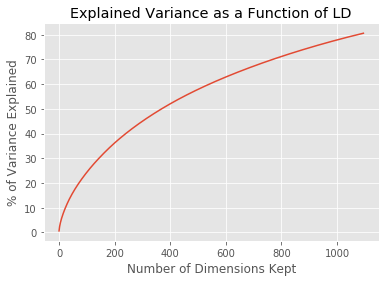

In [102]:
plt.plot(np.cumsum(tsvd.explained_variance_ratio_) * 100)

plt.title("Explained Variance as a Function of LD")
plt.ylabel("% of Variance Explained")
plt.xlabel("Number of Dimensions Kept")

In [103]:
# To ensure interpretable results, keep 250 dimensions only
token_lsa = tsvd.components_[:250, :]

In [104]:
token_to_index = tfidf_vectorizer.vocabulary_
index_to_token = {index:token for token,index in tfidf_vectorizer.vocabulary_.items()}

In [107]:
for topic in range(250):
    print( [index_to_token[ix] for ix in np.argsort( token_lsa[topic, :][::-1] )][:5]  )

['one favorite', 'chow', 'available', 'my husband', 'your order']
['add', 'rolls', 'impressed', 'sandwiches', 'slightly']
['add', 'daughter', 'dipping', 'place you', 'mac']
['add', 'rolls', 'bit', 'lady', 'place so']
['add', 'place so', 'slightly', 'place you', 'drive']
['slightly', 'frozen', 'daughter', 'rolls', 'mac']
['we can', 'not so', 'impressed', 'with your', 'daughter']
['rolls', 'any other', 'remember', 'didn get', 'we can']
['rolls', 'truffle', 'any other', 'not so', 'bit']
['sandwiches', 'rolls', 'came', 'bit', 'we can']
['weird', 'truffle', 'slightly', 'impressed', 'the service great']
['didn get', 'slightly', 'with your', 'not so', 'dessert']
['truffle', 'daughter', 'remember', 'we can', 'sandwiches']
['with side', 'remember', 'daughter', 'flavor', 'didn get']
['with your', 'complaint', 'didn get', 'came', 'weird']
['very well', 'any other', 'came', 'service excellent', 'person']
['have some', 'is', 'didn get', 'daughter', 'rolls']
['truffle', 'bit', 'mac', 'slightly', 'by

In [93]:
dims_to_try = range(10, vec_docs.shape[1], 100)
err = []

for D in dims_to_try:
    
    tsvd = TruncatedSVD(n_components=D, n_iter=10)
    vec_docs_svd = tsvd.fit_transform(vec_docs)
    vec_docs_recovered = tsvd.inverse_transform(vec_docs_svd)
    
    # RMSE error
    mse = np.mean( np.sum( np.square(vec_docs_recovered - vec_docs) ) )
    rmse = np.sqrt(mse)
    
    print(D, rmse)
    err.append(rmse)

10 296.4213055429011
110 251.90803292602382
210 222.5610105826105
310 197.9517407478759
410 175.7483324204837
510 155.1288372133615
610 135.1946286411709
710 115.05154543506755
810 94.13658720660624
910 71.20454260941115
1010 43.79129438135375


In [88]:
vec_docs_recovered

array([[ 0.00502094,  0.0213972 ,  0.01079536, ...,  0.00078716,
         0.00255467, -0.00162265],
       [ 0.0001322 ,  0.01211246,  0.0057581 , ...,  0.00149539,
        -0.00072408,  0.00436658],
       [ 0.00267275, -0.00158494, -0.00353813, ...,  0.00307275,
         0.00096718,  0.00348141],
       ...,
       [ 0.00213505,  0.03330661,  0.0145762 , ...,  0.00166899,
         0.00829869,  0.00868727],
       [ 0.00219832,  0.0239622 ,  0.00405535, ...,  0.00405004,
         0.01472862,  0.00519752],
       [ 0.00069028,  0.03208281,  0.01155056, ..., -0.00041735,
         0.01743496,  0.0072857 ]])

In [78]:
tsvd = TruncatedSVD(n_components=20, n_iter=10)
vec_docs_svd = tsvd.fit_transform(vec_docs)

In [ ]:
tsvd.

In [79]:
tsvd.explained_variance_ratio_.sum()

0.11565606838499905

In [69]:
vec_docs_svd[:10, :]

array([[ 1.30382752e-01,  3.51550727e-03, -7.36547631e-02,
        -1.79300639e-02,  4.03683105e-01, -2.52157109e-02,
         6.12411604e-02, -2.05628273e-02,  4.73207333e-02,
         2.03202908e-02, -3.82416197e-02, -5.21361554e-03,
         1.57888363e-02,  6.28170925e-02,  7.89977705e-03],
       [ 2.01427316e-01, -1.22464578e-01,  6.59113690e-02,
        -9.80687422e-02,  1.06927416e-02, -1.64259581e-01,
         8.46201826e-02,  5.58418959e-02, -5.09567135e-02,
         2.98604904e-02,  7.53993624e-02,  1.01131883e-01,
         6.42969340e-02, -1.21416831e-02,  1.01418748e-01],
       [ 2.78987824e-01, -2.05703063e-02, -8.49212505e-02,
         5.27413718e-02,  1.79902172e-01, -9.40942090e-02,
        -1.32631401e-02, -4.04166262e-02, -1.17055991e-02,
        -4.36944771e-03, -6.13500205e-03,  7.12026831e-03,
         1.99692935e-02, -2.96145192e-05, -3.98965112e-03],
       [ 1.77524963e-01,  6.30234208e-03, -8.57806440e-02,
        -2.34532187e-02,  4.35868544e-01, -5.24198687